# Bayesian Network Structure Learning in Pomegranate

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com
    
Learning the structure of Bayesian networks can be complicated for two main reasons: (1) difficulties in inferring causality and (2) the super-exponential number of directed edges that could exist in a dataset. The first issue presents itself when the structure lerning algorithm considers only correlation or another measure of co-occurrence to determine if an edge should exist. The first point presents challenges which deserve a far more in depth treatment unrelated to implementations in pomegranate, so instead this tutorial will focus on how pomegranate implements fast Bayesian network structure learning. It will also cover a new concept called the "constraint graph" which can be used to massively speed up structure search while also making causality assignment a bit more reasonable.

## Introduction to Bayesian Network Structure Learning

Most methods for Bayesian network structure learning (BNSL) can be put into one of the following three categories: 

(1) Search and Score: The most intuitive method is that of 'search and score,' where one searches over the space of all possible directed acyclic graphs (DAGs) and identifies the one that minimizes some objective function. Typical objective functions attempt to balance the log probability of the data given the model (the likelihood) with the complexity of the model to encourage sparser models. A naive implementation of this search is super-exponential in time with the number of variables, and becomes infeasible when considering even less than a dozen variables. However, dynamic programming can efficiently remove the many repeated calculations and reduce this to be simply exponential in time. This allows exact BNSL to scale to ~25-30 variables. In addition, the A\* algorithm can be used to smartly search the space and reduce computational time even further by not even considering all possibile networks.

(2) Constraint learning: These methods typically involve calculating some measure of correlation or co-occurrence to identify an undirected backbone of edges that could exist, and then prune these edges systematically until a DAG is reached. A common method is to iterate over all triplets of variables to identify conditional independencies that specify both presence and direction of the edges. This algorithm is asymptotically faster (quadratic in time) than search-and-score, but it does not have a simple probabilistic interpretation.

(3) Approximate algorithms: In many real world examples, one wishes to merge the interpretability of the search and score method with the attractiveness of the task finishing before the universe ends. To this end, several heuristics have been developed with different properties to yield good structures in a reasonable amount of time. These methods include the Chow-Liu tree building algorithm, the hill-climbing algorithm, and optimal reinsertion, though there are others.

pomegranate currently implements a search-and-score method based on the minimum description length score which utilizes the dynamic programming and A\* algorithm (DP/A\*), a greedy algorithm based off of DP/A\*, and the Chow-Liu tree building algorithm, though there are plans to soon add other algorithms.

## Structure Learning in pomegranate
### Exact Learning

Structure learning in pomegranate is done using the `from_samples` method. All you pass in is the samples, their associated weights (if not uniform), and the algorithm which you'd like to use, and it will learn the network for you using the dynamic programming implementation. Lets see a quick synthetic example to make sure that appropriate connections are found. Lets add connections between variables 1, 3, 6, and variables 0 and 2, and variables 4 and 5.

Populating the interactive namespace from numpy and matplotlib
((), (), (0,), (1,), (), (4,), (3,))


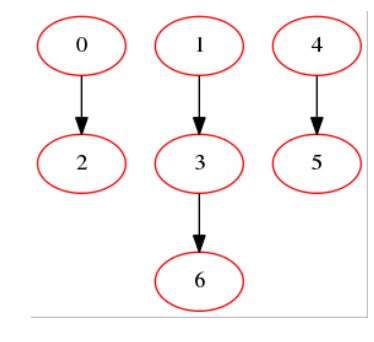

In [1]:
%pylab inline
%load_ext memory_profiler
from pomegranate import BayesianNetwork
import seaborn, time
seaborn.set_style('whitegrid')

X = numpy.random.randint(2, size=(2000, 7))
X[:,3] = X[:,1]
X[:,6] = X[:,1]

X[:,0] = X[:,2]

X[:,4] = X[:,5]

model = BayesianNetwork.from_samples(X, algorithm='exact')
print model.structure
model.plot()

The structure attribute returns a tuple of tuples, where each inner tuple corresponds to that node in the graph (and the column of data learned on). The numbers in that inner tuple correspond to the parents of that node. The results from this structure are that node 3 has node 1 as a parent, that node 2 has node 0 as a parent, and so forth. It seems to faithfully recapture the underlying dependencies in the data.

Now, two algorithms for performing search-and-score were mentioned, the traditional shortest path algorithm and the A\* algorithm. These both work by essentially turning the Bayesian network structure learning problem into a shortest path problem over an 'order graph.' This order graph is a lattice made up of layers of variable sets from the BNSL problem, with the root node having no variables, the leaf node having all variables, and layer `i` in the lattice having all subsets of variables of size `i`. Each path from the root to the leaf represents a certain topological sort of the variables, with the shortest path corresponding to the optimal topological sort and Bayesian network. Details can be found <a href="http://url.cs.qc.cuny.edu/publications/Yuan11learning.pdf">here</a>. The traditional shortest path algorithm calculates the values of all edges in the order lattice before finding the shortest path, while the A\* algorithm searches only a subset of the order lattice and begins searching immediately. Both methods yield optimal Bayesian networks.

A major problem that arises in the traditional shortest path algorithm is that the size of the order graph grows exponentially with the number of variables, and can make tasks infeasible that have otherwise-reasonable computational times. While the A\* algorithm is faster computationally, another advantage is that it uses a much smaller amount of memory since it doesn't explore the full order graph, and so can be applied to larger problems.

In order to see the differences between these algorithms in practice, let's turn to the task of learning a Bayesian network over the digits dataset. The digits dataset is comprised of over a thousand 8x8 pictures of handwritten digits. We binarize the values into 'on' or 'off' for simplicity, and try to learn dependencies between the pixels.

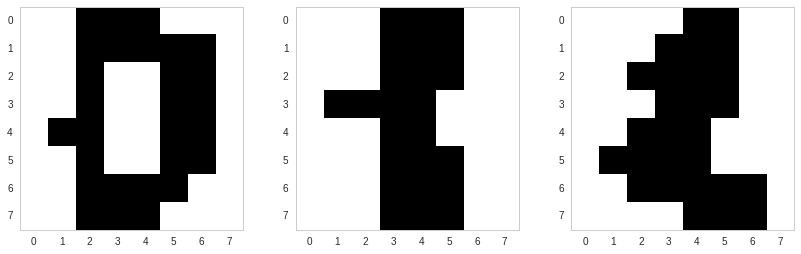

In [2]:
from sklearn.datasets import load_digits

X, y = load_digits(10, True)
X = X > numpy.mean(X)

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.imshow(X[0].reshape(8, 8), interpolation='nearest')
plt.grid(False)
plt.subplot(132)
plt.imshow(X[1].reshape(8, 8), interpolation='nearest')
plt.grid(False)
plt.subplot(133)
plt.imshow(X[2].reshape(8, 8), interpolation='nearest')
plt.grid(False)

In [3]:
X = X[:,:18]
    
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact-dp') # << BNSL done here!
t1 = time.time() - tic
p1 = model.log_probability(X).sum()

tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact')
t2 = time.time() - tic
p2 = model.log_probability(X).sum()


print "Shortest Path"
print "Time (s): ", t1
print "P(D|M): ", p1
%memit BayesianNetwork.from_samples(X, algorithm='exact-dp')
print
print "A* Search"
print "Time (s): ", t2
print "P(D|M): ", p2
%memit BayesianNetwork.from_samples(X, algorithm='exact')

Shortest Path
Time (s):  70.1325659752
P(D|M):  -8267.95044748
peak memory: 2548.30 MiB, increment: 1805.16 MiB

A* Search
Time (s):  54.0429809093
P(D|M):  -8267.95044748
peak memory: 1339.90 MiB, increment: 458.89 MiB


These results show that the A\* algorithm is both computationally faster and requires far less memory than the traditional algorithm, making it a better default for the 'exact' algorithm. The amount of memory used by the BNSL process is under 'increment', not 'peak memory', as 'peak memory' returns the total memory used by everything, while increment shows the difference in peak memory before and after the function has run. 

### Approximate Learning: Greedy Search (pomegranate default)

A natural heuristic when a non-greedy algorithm is too slow is to consider the greedy version. This simple implementation iteratively finds the best variable to add to the growing topological sort, allowing the new variable to draw only from variables already in the topological sort. This is the default in pomegranate because it has a nice balance between producing good (often optimal) graphs and having a small computational cost and memory footprint. However, there is no guarantee that this produces the globally optimal graph.

Let's see how it performs on the same dataset as above.

In [4]:
tic = time.time()
model = BayesianNetwork.from_samples(X) # << Default BNSL setting
t = time.time() - tic
p = model.log_probability(X).sum()

print "Greedy"
print "Time (s): ", t
print "P(D|M): ", p
%memit BayesianNetwork.from_samples(X)

Greedy
Time (s):  3.88651204109
P(D|M):  -8434.74506907
peak memory: 850.02 MiB, increment: 3.01 MiB


### Approximate Learning: Chow-Liu Trees

However, there are even cases where the greedy heuristic is too slow, for example hundreds of variables. One of the first heuristics for BNSL is that of Chow-Liu trees, which learns the optimal tree from data. Essentially it calculates the mutual information between all pairs of variables and then finds the maximum spanning tree. A root node has to be input to turn the undirected edges based on mutual information into directed edges for the Bayesian network. The algorithm is is $O(d^{2})$ and practically is extremely fast and memory efficient, though it produces structures with a worse $P(D|M)$.

In [5]:
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='chow-liu') # << Default BNSL setting
t = time.time() - tic
p = model.log_probability(X).sum()

print "Chow-Liu"
print "Time (s): ", t
print "P(D|M): ", p
%memit BayesianNetwork.from_samples(X, algorithm='chow-liu')

Chow-Liu
Time (s):  0.0929050445557
P(D|M):  -8752.32666094
peak memory: 834.77 MiB, increment: 0.00 MiB


### Comparison

We can then compare the algorithms directly to each other on the digits dataset as we expand the number of pixels to consider.

In [6]:
X, _ = load_digits(10, True)
X = X > numpy.mean(X)

t1, t2, t3, t4 = [], [], [], []
p1, p2, p3, p4 = [], [], [], []
n_vars = range(8, 19)

for i in n_vars:
    X_ = X[:,:i]

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact-dp') # << BNSL done here!
    t1.append(time.time() - tic)
    p1.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact')
    t2.append(time.time() - tic)
    p2.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='greedy')
    t3.append(time.time() - tic)
    p3.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='chow-liu')
    t4.append(time.time() - tic)
    p4.append(model.log_probability(X_).sum())

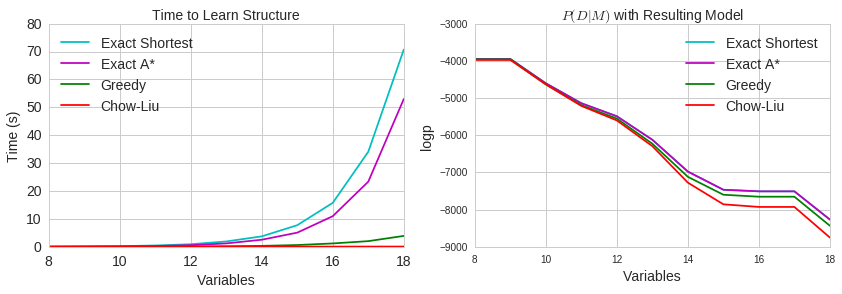

In [7]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title("Time to Learn Structure", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.plot(n_vars, t1, c='c', label="Exact Shortest")
plt.plot(n_vars, t2, c='m', label="Exact A*")
plt.plot(n_vars, t3, c='g', label="Greedy")
plt.plot(n_vars, t4, c='r', label="Chow-Liu")
plt.legend(fontsize=14, loc=2)

plt.subplot(122)
plt.title("$P(D|M)$ with Resulting Model", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.ylabel("logp", fontsize=14)
plt.plot(n_vars, p1, c='c', label="Exact Shortest")
plt.plot(n_vars, p2, c='m', label="Exact A*")
plt.plot(n_vars, p3, c='g', label="Greedy")
plt.plot(n_vars, p4, c='r', label="Chow-Liu")
plt.legend(fontsize=14)

We can see the expected results-- that the A\* algorithm works faster than the shortest path, the greedy one faster than that, and Chow-Liu the fastest. The purple and cyan lines superimpose on the right plot as they produce graphs with the same score, followed closely by the greedy algorithm and then Chow-Liu performing the worst.

## Constraint Graphs

Now, sometimes you have prior information about how groups of nodes are connected to each other and want to exploit that. This can take the form of a global ordering, where variables can be ordered in such a manner that edges only go from left to right, for example. However, sometimes you have layers in your network where variables are a part of these layers and can only have parents in another layer.

Lets consider a diagnostics Bayesian network like the following (no need to read code, the picture is all that is important for now):

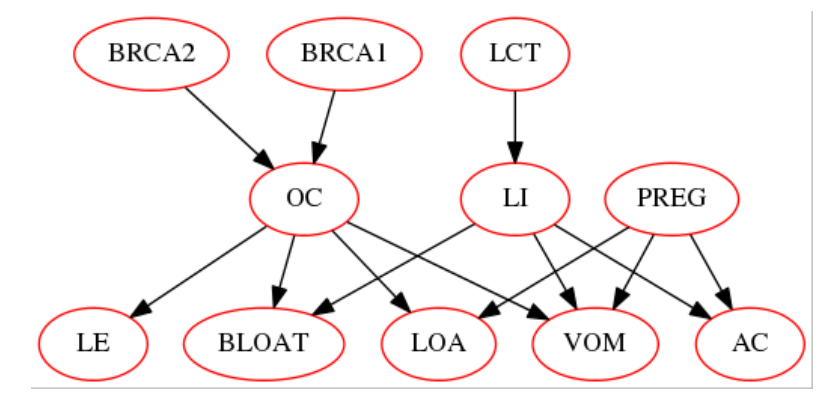

In [8]:
from pomegranate import DiscreteDistribution, ConditionalProbabilityTable, Node

BRCA1 = DiscreteDistribution({0: 0.999, 1: 0.001})
BRCA2 = DiscreteDistribution({0: 0.985, 1: 0.015})
LCT   = DiscreteDistribution({0: 0.950, 1: 0.050})

OC = ConditionalProbabilityTable([[0, 0, 0, 0.999],
                                  [0, 0, 1, 0.001],
                                  [0, 1, 0, 0.750],
                                  [0, 1, 1, 0.250],
                                  [1, 0, 0, 0.700],
                                  [1, 0, 1, 0.300],
                                  [1, 1, 0, 0.050],
                                  [1, 1, 1, 0.950]], [BRCA1, BRCA2])

LI = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.20],
                                  [1, 1, 0.80]], [LCT])

PREG = DiscreteDistribution({0: 0.90, 1: 0.10})

LE = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.25],
                                  [1, 1, 0.75]], [OC])

BLOAT = ConditionalProbabilityTable([[0, 0, 0, 0.85],
                                     [0, 0, 1, 0.15],
                                     [0, 1, 0, 0.70],
                                     [0, 1, 1, 0.30],
                                     [1, 0, 0, 0.40],
                                     [1, 0, 1, 0.60],
                                     [1, 1, 0, 0.10],
                                     [1, 1, 1, 0.90]], [OC, LI])

LOA = ConditionalProbabilityTable([[0, 0, 0, 0.99],
                                   [0, 0, 1, 0.01],
                                   [0, 1, 0, 0.30],
                                   [0, 1, 1, 0.70],
                                   [1, 0, 0, 0.95],
                                   [1, 0, 1, 0.05],
                                   [1, 1, 0, 0.95],
                                   [1, 1, 1, 0.05]], [PREG, OC])

VOM = ConditionalProbabilityTable([[0, 0, 0, 0, 0.99],
                                   [0, 0, 0, 1, 0.01],
                                   [0, 0, 1, 0, 0.80],
                                   [0, 0, 1, 1, 0.20],
                                   [0, 1, 0, 0, 0.40],
                                   [0, 1, 0, 1, 0.60],
                                   [0, 1, 1, 0, 0.30],
                                   [0, 1, 1, 1, 0.70],
                                   [1, 0, 0, 0, 0.30],
                                   [1, 0, 0, 1, 0.70],
                                   [1, 0, 1, 0, 0.20],
                                   [1, 0, 1, 1, 0.80],
                                   [1, 1, 0, 0, 0.05],
                                   [1, 1, 0, 1, 0.95],
                                   [1, 1, 1, 0, 0.01],
                                   [1, 1, 1, 1, 0.99]], [PREG, OC, LI])

AC = ConditionalProbabilityTable([[0, 0, 0, 0.95],
                                  [0, 0, 1, 0.05],
                                  [0, 1, 0, 0.01],
                                  [0, 1, 1, 0.99],
                                  [1, 0, 0, 0.40],
                                  [1, 0, 1, 0.60],
                                  [1, 1, 0, 0.20],
                                  [1, 1, 1, 0.80]], [PREG, LI])

s1 = Node(BRCA1, name="BRCA1")
s2 = Node(BRCA2, name="BRCA2")
s3 = Node(LCT, name="LCT")
s4 = Node(OC, name="OC")
s5 = Node(LI, name="LI")
s6 = Node(PREG, name="PREG")
s7 = Node(LE, name="LE")
s8 = Node(BLOAT, name="BLOAT")
s9 = Node(LOA, name="LOA")
s10 = Node(VOM, name="VOM")
s11 = Node(AC, name="AC")

model = BayesianNetwork("Hut")
model.add_nodes(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
model.add_edge(s1, s4)
model.add_edge(s2, s4)
model.add_edge(s3, s5)
model.add_edge(s4, s7)
model.add_edge(s4, s8)
model.add_edge(s4, s9)
model.add_edge(s4, s10)
model.add_edge(s5, s8)
model.add_edge(s5, s10)
model.add_edge(s5, s11)
model.add_edge(s6, s9)
model.add_edge(s6, s10)
model.add_edge(s6, s11)
model.bake()

plt.figure(figsize=(14, 10))
model.plot()
plt.show()

This network contains three layer, with symptoms on the bottom (low energy, bloating, loss of appetite, vomitting, and abdominal cramps), diseases in the middle (overian cancer, lactose intolerance, and pregnancy), and genetic tests on the top for three different genetic mutations. The edges in this graph are constrainted such that symptoms are explained by diseases, and diseases can be partially explained by genetic mutations. There are no edges from diseases to genetic conditions, and no edges from genetic conditions to symptoms. If we were going to design a more efficient search algorithm, we would want to exploit this fact to drastically reduce the search space of graphs.

Before presenting a solution, lets also consider another situation. In some cases you can define a global ordering of the variables, meaning you can order them from left to right and ensure that edges only go from the left to the right. This can represent some temporal separation (things on the left happen before things on the right), physical separation, or anything else. This would also dramatically reduce the search space. 

In addition to reducing the search space, an efficient algorithm can exploit this layered structure. A key property of most scoring functions is the idea of "global parameter independence", meaning that that the parents of node A are independent of the parents of node B assuming that they do not form a cycle in the graph. If you have a layered structure, either like in the diagnostics network or through a global ordering, it is impossible to form a cycle in the graph through any valid assignment of parent values. This means that the parents for each node can be identified independently, drastically reducing the runtime of the algorithm.

Now, sometimes we know ~some things~ about the structure of the variables, but nothing about the others. For example, we might have a partial ordering on some variables but not know anything about the others. We could enforce an arbitrary ordering on the others, but this may not be well justified. In essence, we'd like to exploit whatever information we have.

Abstractly, we can think about this in terms of constraint graphs. Lets say you have some symptoms, diseases, and genetic tests, and don't a priori know the connection between all of these pieces, but you do know the previous layer structure. You can define a "constraint graph" which is made up of three nodes, "symptoms", "diseases", and "genetic mutations". There is a directed edge from genetic mutations to diseases, and a directed edge from diseases to symptoms. This specifies that genetic mutations can be parents to diseases, and diseases to symptoms. It would look like the following:

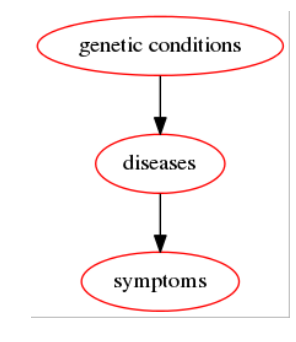

In [9]:
import networkx
from pomegranate.utils import plot_networkx

constraints = networkx.DiGraph()
constraints.add_edge('genetic conditions', 'diseases')
constraints.add_edge('diseases', 'symptoms')
plot_networkx(constraints)

All variables corresponding to these categories would be put in their appropriate name. This would define a scaffold for structure learning.

Now, we can do the same thing for a global ordering. Lets say we have 3 variables in an order from 0-2. 

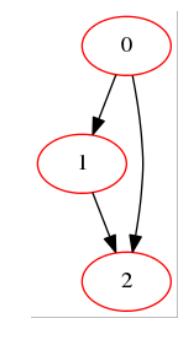

In [10]:
constraints = networkx.DiGraph()
constraints.add_edge(0, 1)
constraints.add_edge(1, 2)
constraints.add_edge(0, 2)
plot_networkx(constraints)

In this graph, we're saying that variable 0 can be a parent for 1 or 2, and that variable 1 can be a parent for variable 2. In the same way that putting multiple variables in a node of the constraint graph allowed us to define layers, putting a single variable in the nodes of a constraint graph can allow us to define an ordering.

To be specific, lets say we want to find the parents of the variables in node 1 given that those variables parents can only come from the variables in node 0. We can independently find the best parents for each variable in node 1 from the set of those in node 0. This is significantly faster than trying to find the best Bayesian network of all variables in nodes 0 and 1. We can also do the same thing for the variables in node 2 by going through the variables in both nodes 0 and 1 to find the best parent set for the variables in node 2.

However, there are some cases where we know nothing about the parent structure of some variables. This can be solved by including self-loops in the graph, where a node is its own parent. This means that we know nothing about the parent structure of the variables in that node and that the full exponential time algorithm will have to be run. The naive structure learning algorithm can be thought of as putting all variables in a single node in the constraint graph and putting a self-loop on that node. 

We are thus left with two procedures; one for solving edges which are self edges, and one for solving edges which are not. Even though we have to use the exponential time procedure on variables in nodes with self loops, it will still be significantly faster because we will be using less variables (except in the naive case).

Frequently though we will have some information about some of the nodes of the graph even if we don't have information about all of the nodes. Lets take the case where we know some variables have no children but can have parents, and know nothing about the other variables.

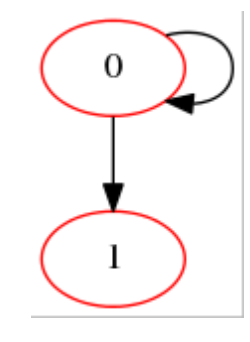

In [11]:
constraints = networkx.DiGraph()
constraints.add_edge(0, 1)
constraints.add_edge(0, 0)
plot_networkx(constraints)

In this situation we would have to run the exponential time algorithm on the variables in node 0 to find the optimal parents, and then run the independent parents algorithm on the variables in node 1 drawing only from the variables in node 0. To be specific:

(1) Use exponential time procedure to find optimal structure amongst variables in node 0 
(2) Use independent-parents procedure to find the best parents of variables in node 1, restricting the parents to be in node 0
(3) Concatenate these parent sets together to get the optimal structure of the network given the constraints.

We can generalize this to any arbitrary constraint graph:

(1) Use exponential time procedure to find optimal structure amongst variables in nodes with self loops (including parents from other nodes if needed)
(2) Use independent-parents procedure to find best parents of variables in a node given the constraint that the parents must come from variables in the node which is this nodes parent
(3) Concatenate these parent sets together to get the optimal structure of the network given the constraints.

According to the global parameter independence property of Bayesian networks, this procedure will give the globally optimal Bayesian network while exploring a significantly smaller part of the network.

pomegranate supports constraint graphs in an extremely easy to use manner. Lets say that we have a graph with three layers like the diagnostic model, and five variables in each layer. We can define the constraint graph as a networkx DiGraph, with the nodes being tuples containing the column ids of each variable belonging to that variable.

In this case, we're saying that (0, 1, 2, 3, 4) is the first node, (5, 6, 7, 8, 9) is the second node, and (10, 11, 12, 13, 14) is the final node. Lets make nodes 1, 7, and 12 related, 11, 13, 14 related, and 3 and 5 related. In this case, where should be an edge from 1 to 7, and 7 to 12. 11, 13, and 14 are all a part of the same layer and so that connection should be ignored, and then there should be a connection from 3 to 5.

Constraint Graph


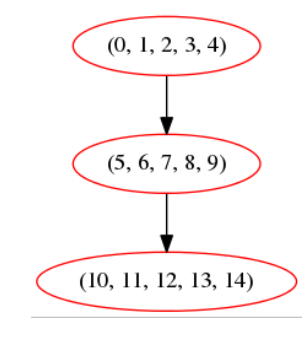

Learned Bayesian Network


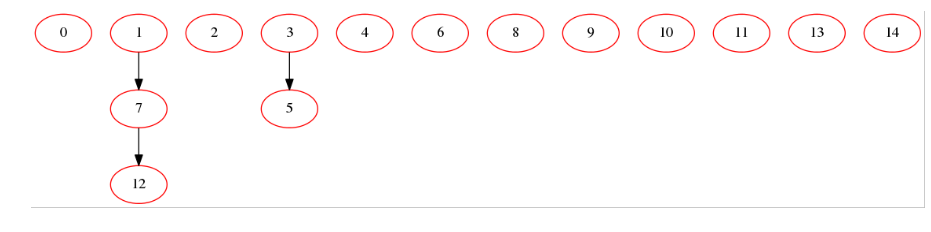

pomegranate time:  0.339829921722 ((), (), (), (), (), (3,), (), (1,), (), (), (), (), (7,), (), ())


In [12]:
numpy.random.seed(6)

X = numpy.random.randint(2, size=(200, 15))

X[:,1] = X[:,7]
X[:,12] = 1 - X[:,7]

X[:,5] = X[:,3]

X[:,13] = X[:,11]
X[:,14] = X[:,11]

a = networkx.DiGraph()
b = tuple((0, 1, 2, 3, 4))
c = tuple((5, 6, 7, 8, 9))
d = tuple((10, 11, 12, 13, 14))

a.add_edge(b, c)
a.add_edge(c, d)
print "Constraint Graph"
plot_networkx(a)
plt.show()

print "Learned Bayesian Network"

tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact', constraint_graph=a)

plt.figure(figsize=(16, 8))
model.plot()
plt.show()
print "pomegranate time: ", time.time() - tic, model.structure

We see that reconstructed perfectly here. Lets see what would happen if we didn't use the exact algorithm.

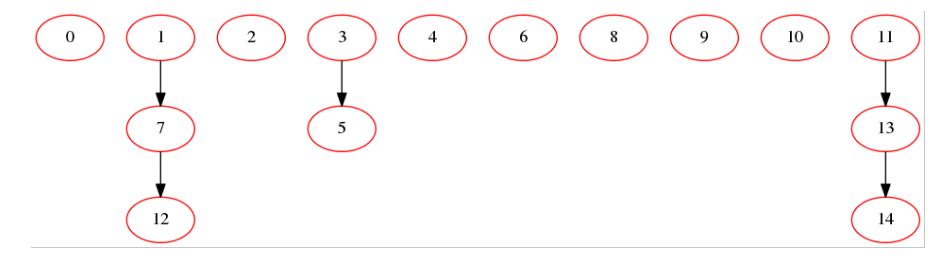

pomegranate time:  3.44430494308 ((), (), (), (), (), (3,), (), (1,), (), (), (), (), (7,), (11,), (13,))


In [13]:
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact')
plt.figure(figsize=(16, 8))
model.plot()
plt.show()
print "pomegranate time: ", time.time() - tic, model.structure

It looks like we got three desirable attributes by using a constraint graph. The first is that there was over an order of magnitude speed improvement in finding the optimal graph. The second is that we were able to remove some edges we didn't want in the final Bayesian network, such as those between 11, 13, and 14. We also removed the edge between 1 and 12 and 1 and 3, which are spurious given the model that we originally defined. The third desired attribute is that we can specify the direction of some of the edges and get a better causal model.

Lets take a look at how big of a model we can learn given a three layer constraint graph like before. 

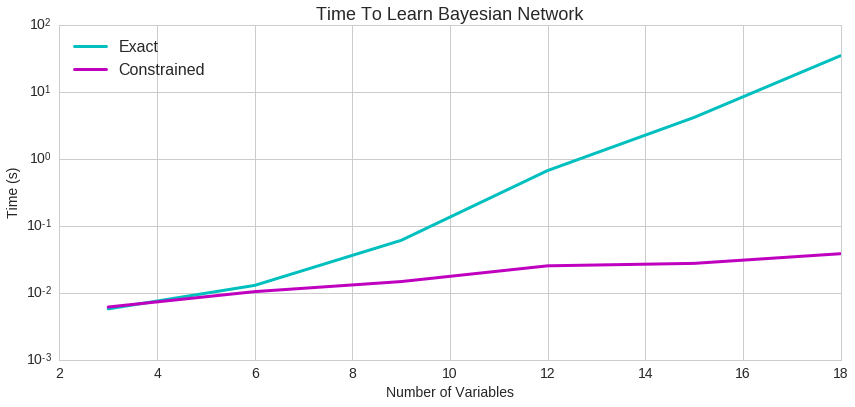

In [14]:
constraint_times, times = [], []

x = numpy.arange(1, 7)
for i in x:
    symptoms = tuple(range(i))
    diseases = tuple(range(i, i*2))
    genetic = tuple(range(i*2, i*3))

    constraints = networkx.DiGraph()
    constraints.add_edge(genetic, diseases)
    constraints.add_edge(diseases, symptoms)
    
    X = numpy.random.randint(2, size=(2000, i*3))
    
    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='exact', constraint_graph=constraints)
    constraint_times.append( time.time() - tic )
    
    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='exact')
    times.append( time.time() - tic )  


plt.figure(figsize=(14, 6))
plt.title('Time To Learn Bayesian Network', fontsize=18)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot( x*3, times, linewidth=3, color='c', label='Exact')
plt.plot( x*3, constraint_times, linewidth=3, color='m', label='Constrained')
plt.legend(loc=2, fontsize=16)
plt.yscale('log')

Looks like by including a constraint graph, we can far more quickly find the optimal Bayesian network. This can allow us to create Bayesian networks on dozens of variables as long as we can order them into layers.

## Other Parameters

There are three other parameters that are worth mentioning. The first is that a vector of weights can be passed in alongside a matrix of samples, with each entry in the vector corresponding to the weight of that sample. By default all weights are set to 1, but they can be any non-negative number.

```
model = BayesianNetwork.from_samples(X, weights=weights)
```

Next is the pseudocounts parameter that indicates the number added to the observations of each observed variable combination. This acts as a regularizer by smoothing over the counts and is typically used to prevent the model from saying it is impossible for a combination of variables to occur together just because they weren't observed in the data. Currently all learning algorithms support pseudocounts. By default this is set to 0.

```
model = BayesianNetwork.from_samples(X, pseudocount=1.7
```

Lastly, the maximum number of parents that each variable can have can be limited. This is sometimes referred to as the k-learn problem in literature. In practice this can dramatically speed up the BNSL task as the majority of time is spent determining the best parent sets. Currently this only affects the exact and greedy algorithm as in the Chow-Liu algorithm each variable only has a single parent.

```
model = BayesianNetwork.from_samples(X, algorithm='exact', max_parents=2)
```

Since exact inference uses minimum description length as a score function, the maximum number of parents is by default set to $\log \left(\frac{n}{\log(n)} \right)$ with $n$ being the number of samples in the dataset.

# Conclusions

pomegranate currently supports exact BNSL through an a shortest path dynamic programming algorithm, an A\* algorithm, a greedy algorithm, the Chow-Liu tree building algorithm, and a constraint-graph based algorithm which can significantly speed up structure learning if you have any prior knowledge of the interactions between variables.

If you have any suggestions for how to improve pomegranate or ideas for algorithms to implement, feel free to open an issue on the issue tracker! I'd love to hear feedback.